In [26]:
___Author___='LumberJack Jyss'

# LSTM FROM KEREAS

In [27]:
#importing required libraries
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from keras.models import *
from keras.layers import *
from keras import losses
from keras.utils.vis_utils import plot_model as plot
from matplotlib.legend_handler import HandlerLine2D
from pandas import read_csv
from matplotlib import pyplot

In [28]:
#setting figure size
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [29]:
# Setting the data
start = pd.to_datetime('2016-03-31')
end = pd.to_datetime('2019-03-28')
delta = round((end-start).days)
bloc1 = round(delta*0.8)
bloc2 = delta - bloc1
print("Période d'étude : ",delta)
print('Sur un découpage 80% - 20% de la période : ')
print('Bloc 1 : ',bloc1,' jours \nBloc 2 :',bloc2,' jours')
print('Note : On change de règles de calculs, car tous les jours ne sont pas ouvrés')

Période d'étude :  1092
Sur un découpage 80% - 20% de la période : 
Bloc 1 :  874  jours 
Bloc 2 : 218  jours
Note : On change de règles de calculs, car tous les jours ne sont pas ouvrés


In [30]:
dataset = web.DataReader('AMZN','yahoo',start,end)
#spy_etf = web.DataReader('SPY','yahoo',start,end)

dataset = dataset.drop(['Low','Close'],axis=1)

In [31]:
print("Longueur du dataset : ",len(dataset))

Longueur du dataset :  754


In [32]:
# Shift Adj Close minus one
#dataset['Adj Close'] = dataset['Adj Close'].shift(-1)
#dataset.tail()

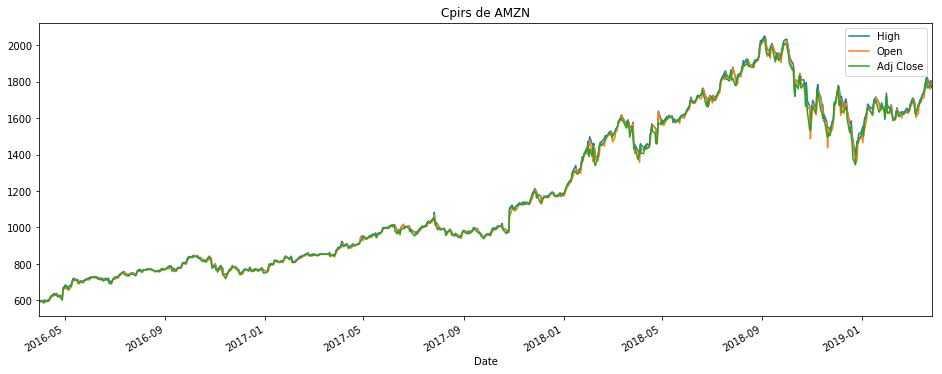

In [33]:
dataset[['High','Open','Adj Close']].plot(figsize=(16,6),title='Cpirs de AMZN')

In [34]:
print('Nombre de valeurs nulles dans le dataset :')
dataset.isnull().sum().sum()

Nombre de valeurs nulles dans le dataset :


0

In [35]:
print('Informations sur le dataset (sur les colonnes, ainsi que leur type)')
dataset.info()

Informations sur le dataset (sur les colonnes, ainsi que leur type)
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 754 entries, 2016-03-31 to 2019-03-28
Data columns (total 4 columns):
High         754 non-null float64
Open         754 non-null float64
Volume       754 non-null int64
Adj Close    754 non-null float64
dtypes: float64(3), int64(1)
memory usage: 29.5 KB


In [36]:
# save to file
print('Le fichier est sauvegardé en local sous format csv')
dataset.to_csv('AMZN.csv')

Le fichier est sauvegardé en local sous format csv


In [37]:
# load dataset
print('On recharge le fichier csv pour partir sur cette base ainsi arrangée :')
dataset = read_csv('AMZN.csv', header=0, index_col=0)

On recharge le fichier csv pour partir sur cette base ainsi arrangée :


In [38]:
print('Début du dataset :\n',dataset.head())
print('Fin du dataset :\n',dataset.tail())

Début du dataset :
                   High        Open   Volume   Adj Close
Date                                                   
2016-03-31  600.750000  599.280029  2681800  593.640015
2016-04-01  599.030029  590.489990  2917400  598.500000
2016-04-04  599.500000  599.000000  2470800  593.190002
2016-04-05  593.469971  590.770020  2308900  586.140015
2016-04-06  602.390015  587.520020  2833500  602.080017
Fin du dataset :
                    High         Open   Volume    Adj Close
Date                                                      
2019-03-22  1818.979980  1810.170044  6363000  1764.770020
2019-03-25  1782.680054  1757.790039  5103800  1774.260010
2019-03-26  1805.770020  1793.000000  4865900  1783.760010
2019-03-27  1787.500000  1784.130005  4324800  1765.699951
2019-03-28  1777.930054  1770.000000  3043000  1773.420044


In [39]:
print('On transforme le dataframe en arrays par la fonction ".values"')
values = dataset.values
# specify columns to plot

On transforme le dataframe en arrays par la fonction ".values"


On trace alors les plots des différentes colonnes


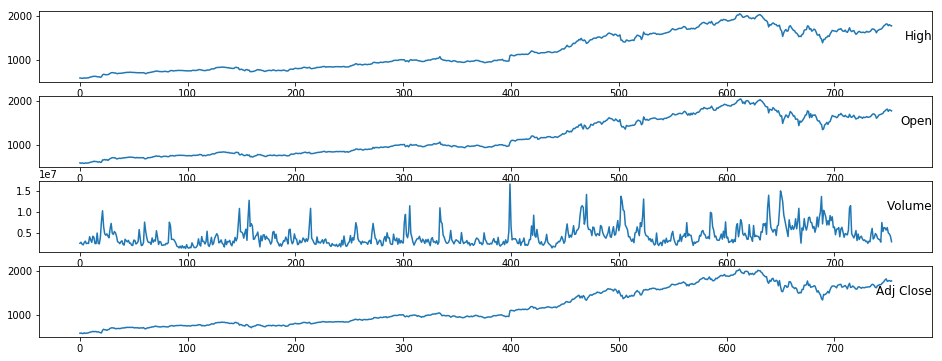

In [40]:
groups = [0, 1, 2, 3]
i = 1
# plot each column
print('On trace alors les plots des différentes colonnes')
pyplot.figure(figsize=(16,6))
for group in groups:
	pyplot.subplot(len(groups), 1, i)
	pyplot.plot(values[:, group])
	pyplot.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
pyplot.show()

In [41]:
print('On normalize alors tous les features pour transformer le dataset dans un supervised learning problem.\
 La variable pour le jour qui doit être prédit(d) est alors enlevée')

On normalize alors tous les features pour transformer le dataset dans un supervised learning problem. La variable pour le jour qui doit être prédit(d) est alors enlevée


In [48]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(d-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(d)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(d+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 
# load dataset
dataset = read_csv('AMZN.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction

#encoder = LabelEncoder()
#values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
#Xscaler = MinMaxScaler(feature_range=(0, 1))
#yscaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
#frame as supervised learning
reframed = series_to_supervised(scaled, 1, 2)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[0,1,2,3,7,8,9,10]], axis=1, inplace=True)
print('Début de model :\n',reframed.head(),'Shape :  ',reframed.shape)
print('\nFin de model :\n',reframed.tail())

# split into train and test sets
train_X = reframed[0:bloc1,:3]
test_X = reframed[bloc1:len(reframed),:3]
train_y = reframed[0:bloc1,3]
test_y = reframed[bloc1:len(reframed),3]

Début de model :
     var1(d)   var2(d)   var3(d)  var4(d+1)
1  0.003816  0.002047  0.096556   0.004851
2  0.004139  0.007914  0.066992   0.000000
3  0.000000  0.002240  0.056275   0.010968
4  0.006122  0.000000  0.091002   0.003640
5  0.004207  0.007749  0.114536   0.005821 Shape :   (752, 4)

Fin de model :
       var1(d)   var2(d)   var3(d)  var4(d+1)
748  0.844375  0.833275  0.285247   0.810964
749  0.841101  0.842864  0.324648   0.817493
750  0.816188  0.806755  0.241292   0.824030
751  0.832035  0.831027  0.225543   0.811603
752  0.819496  0.824913  0.189723   0.816915


TypeError: '(slice(0, 874, None), slice(None, 3, None))' is an invalid key

In [47]:
print('Define and Fit Model')

Define and Fit Model


In [44]:
trainXshape = train_X.shape
testXshape = test_X.shape
trainYshape = train_y.shape
testYshape = test_y.shape
print('On a donc 4 jeux de données, train_X, test_X, train_y et test_y, de dimensions respectives :\n')

print('train_X : ',trainXshape)
print('test_X : ',testXshape)
print('train_y : ',trainYshape)
print('test_y',testYshape)

TypeError: '(slice(0, 874, None), slice(None, 3, None))' is an invalid key

In [20]:
print("L'algorithm ne reçoit qu'un shape de type [samples,timesteps, features]. Or notre préparation n'est qu'en 2D.\
\nIl faut donc lui rajouter la dimension manquante, 'timestep' [ici, 1]. On passe alors un reshape sur train_X et test_X")
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
#Xscaled = Xscaler.fit_transform(train_X,test_X)



L'algorithm ne reçoit qu'un shape de type [samples,timesteps, features]. Or notre préparation n'est qu'en 2D.
Il faut donc lui rajouter la dimension manquante, 'timestep' [ici, 1]. On passe alors un reshape sur train_X et test_X


NameError: name 'train_X' is not defined

In [ ]:
print("On peut maintenant définir notre modèle LSTM (model). De base, on le définit avec 350 neurones dans la \
première couche cachée.\n Il n'y aura qu'un neurone dans la couche de sortie, qui sera la prédiction du Close.\n \
En input, on aura 3 couches, 'high', 'open', et 'volum'.\n On va utiliser le mean absolute error (MAE) \
loss function et la version Adam du gradient d edesente stochastique.\n ")

In [ ]:
# design network
model = Sequential()
model.add(LSTM(350, input_shape=(1, trainXshape[2])))
model.add(Activation('tanh'))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=1, batch_size=1, validation_data=(test_X, test_y), verbose=1, shuffle=False)

In [ ]:
# plot history
plt.figure(figsize = (16, 6))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
# make predictions
trainPredict = model.predict(train_X)
print(trainPredict.shape)

In [ ]:
testPredict = model.predict(test_X)
print(testPredict.shape)

In [ ]:
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
#train_y = train_y.reshape(149,4)
testPredict = scaler.inverse_transform(testPredict)

In [ ]:
test_y = scaler.inverse_transform(test_y.reshape(-1,1))

In [ ]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()